# Forecasting Using DARTS

Dataset URL: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv

In [2]:
import pandas as pd
from darts import TimeSeries
import numpy as np
import random
from matplotlib import pyplot as plt
plt.set_cmap('jet')

import seaborn as sns
from tqdm import tqdm
from datetime import datetime as dt, timedelta

from darts.models import Prophet, NBEATSModel, ExponentialSmoothing, NaiveMovingAverage, Croston, ARIMA
from darts.utils.missing_values import fill_missing_values
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.seasonal import STL

SEED = 123
random.seed(SEED)
np.random.seed(SEED)

<Figure size 640x480 with 0 Axes>

In [3]:
df = pd.read_csv('./Dataset/forecasting/store_sales/train.csv')
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
df = df.drop('id', axis=1, errors='ignore')
df['date'] = pd.to_datetime(df['date'])
df['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [5]:
df.isna().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [30]:
df['store_nbr'].nunique()

54

In [6]:
def cv2_score(series): return (np.std(series,ddof=1)/np.mean(series))**2
def adi_score(series): return len(series)/np.count_nonzero(series)

def classify_demand(cv2, adi):
    if cv2 < 0.49 and adi < 1.32: return 'Smooth'
    if cv2 < 0.49 and adi >= 1.32: return 'Intermittent'
    if cv2 >= 0.49 and adi < 1.32: return 'Erratic'
    if cv2 >= 0.49 and adi >= 1.32: return 'Lumpy'

cat_df = []
for i in tqdm(df['family'].unique()):
    x = df[df['family']==i]
    x = x.groupby('date')[['sales','onpromotion']].sum().reset_index()
    x['month'] = pd.to_datetime(x['date'].dt.strftime('%Y-%m'))
    cv2_val = cv2_score(x['sales'])
    adi_val = adi_score(x['sales'])
    cat_df.append({'category':i, 'cv2':cv2_val, 'adi':adi_val,'class':classify_demand(cv2_val, adi_val)})
    
cat_df = pd.DataFrame(cat_df)
display(cat_df)

100%|██████████| 33/33 [00:06<00:00,  5.20it/s]


,category,cv2,adi,class
0,AUTOMOTIVE,0.108706,1.000594,Smooth
1,BABY CARE,1.772913,1.890011,Lumpy
2,BEAUTY,0.250428,1.000000,Smooth
3,BEVERAGES,0.240051,1.000000,Smooth
4,BOOKS,11.507761,5.867596,Lumpy
5,BREAD/BAKERY,0.067736,1.000000,Smooth
6,CELEBRATION,0.818016,1.652601,Lumpy
7,CLEANING,0.069000,1.000000,Smooth
8,DAIRY,0.128471,1.000000,Smooth
9,DELI,0.084900,1.000000,Smooth


In [7]:
cat_df['class'].value_counts()

class
Smooth     18
Lumpy      11
Erratic     4
Name: count, dtype: int64

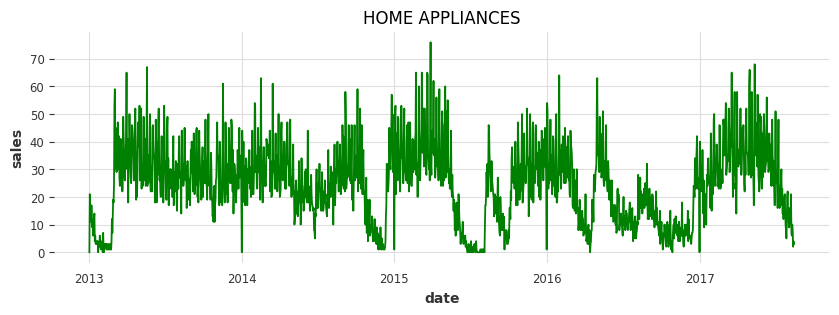

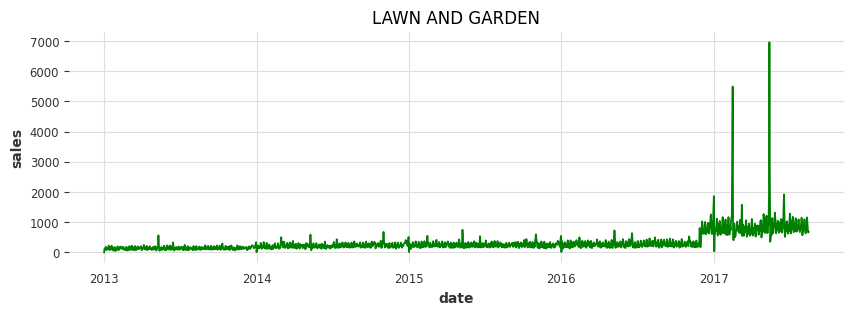

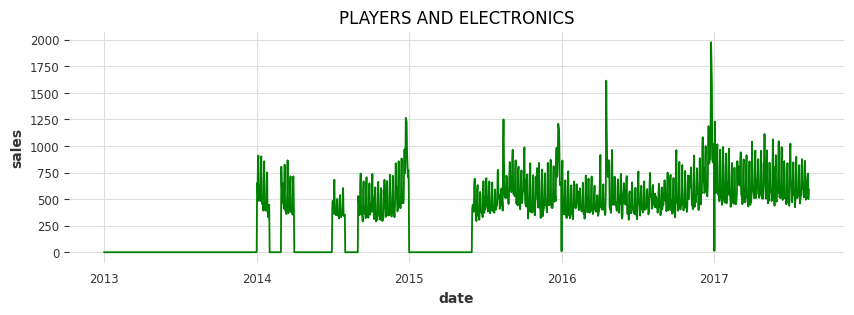

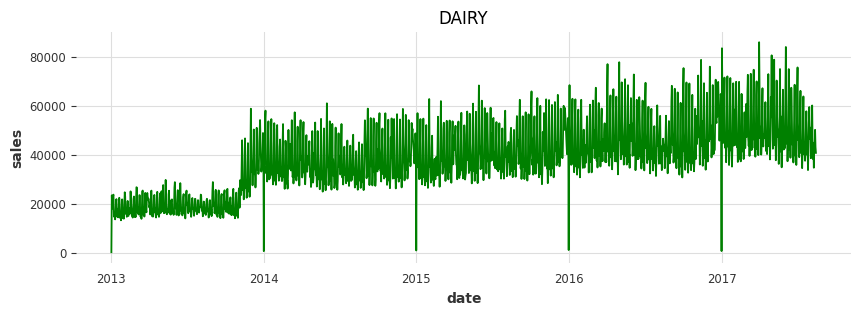

In [6]:
def plot_series(data, x_col, y_col, title, color='green'):
    f, axes = plt.subplots(1, 1, figsize=(10, 3))
    # plt.figure(figsize=(10, 2))
    sns.lineplot(data=data, x=x_col, y=y_col, color=color, ax=axes)
    plt.title(title)
    plt.show()

selected_categories = ['HOME APPLIANCES','LAWN AND GARDEN', 'PLAYERS AND ELECTRONICS','DAIRY']

for i in selected_categories:
    x = df[df['family']==i]
    x = x.groupby('date')[['sales','onpromotion']].sum().reset_index()
    
    plot_series(x, 'date', 'sales', i)

## Preprocess The Data

In [8]:
def generate_ts_data(df,selected_category:str, split_time:dt=None):
    ts_data = df[df['family'] == selected_category].reset_index(drop=True)
    ts_data = ts_data.groupby('date')[['sales','onpromotion']].sum().reset_index()
    
    if split_time:
        data_train = ts_data[ts_data['date'] < split_time]
        data_test = ts_data[ts_data['date'] >= split_time]
        return TimeSeries.from_dataframe(data_train, "date", "sales",freq="D"), TimeSeries.from_dataframe(data_test, "date", "sales",freq="D")
    else:
        return TimeSeries.from_dataframe(ts_data, "date", "sales",freq="D")

In [9]:
full_data = generate_ts_data(df, 'HOME APPLIANCES')
full_data = fill_missing_values(full_data,fill=0.0)

In [10]:
full_data

<TimeSeries (DataArray) (date: 1688, component: 1, sample: 1)> Size: 14kB
array([[[ 0.]],

       [[21.]],

       [[15.]],

       ...,

       [[ 2.]],

       [[ 4.]],

       [[ 3.]]])
Coordinates:
  * date       (date) datetime64[ns] 14kB 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='date'>

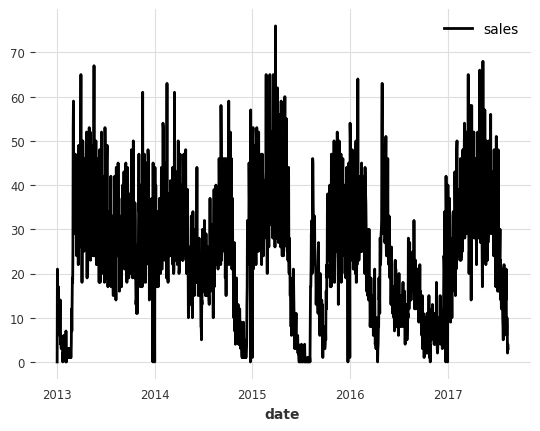

In [9]:
full_data.plot()

In [11]:
model = NaiveMovingAverage(input_chunk_length=7)
model.fit(full_data)

NaiveMovingAverage(input_chunk_length=7)

In [12]:
y_pred = model.historical_forecasts(full_data,forecast_horizon=1,start=pd.Timestamp('2016-07-26'))


In [16]:
y_pred

<TimeSeries (DataArray) (time: 386, component: 1, sample: 1)> Size: 3kB
array([[[11.71428571]],

       [[10.42857143]],

       [[10.85714286]],

       [[ 9.85714286]],

       [[ 9.71428571]],

       [[ 9.57142857]],

       [[ 9.14285714]],

       [[ 9.14285714]],

       [[ 9.28571429]],

       [[ 8.71428571]],

...

       [[14.57142857]],

       [[14.        ]],

       [[12.85714286]],

       [[13.85714286]],

       [[12.57142857]],

       [[12.14285714]],

       [[12.28571429]],

       [[11.71428571]],

       [[ 9.71428571]],

       [[ 8.28571429]]])
Coordinates:
  * time       (time) datetime64[ns] 3kB 2016-07-26 2016-07-27 ... 2017-08-15
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [22]:
def backtest_model(model, data, forecast_horizon=7, test_time:dt=dt(2020,1,1)):
    test_idx = data.get_index_at_point(pd.Timestamp(test_time))
    y_pred = model.historical_forecasts(data,forecast_horizon=forecast_horizon,start=pd.Timestamp(test_time-timedelta(days=forecast_horizon-1)))
    res_dict = {}

    y_pred = y_pred.values().squeeze()
    y_test = data[test_idx:].values().squeeze()
    res_dict['mae'] = mean_absolute_error(y_test,y_pred)
    res_dict['rmse'] = np.sqrt(mean_squared_error(y_test,y_pred))
    res_dict['mape'] = mean_absolute_percentage_error(y_test,y_pred)
    res_dict['r2'] = r2_score(y_test,y_pred)
    res_dict['horizon'] = forecast_horizon
    return pd.DataFrame([res_dict])


In [ ]:
backtest_model(model=model, data=full_data, forecast_horizon=1, test_time=dt(2016,8,1))

,mae,rmse,mape,r2,horizon
0,6.826475,8.956943,4.586903e+14,0.615332,7


In [27]:
full_data.values().max()

76.0

## Packing Them Together

In [28]:
def train_forecasting_model(data: pd.DataFrame, model_name: str = 'MA', forecast_horizon: int = 7, tgt_category: str = 'HOME APPLIANCES', test_time: dt = dt(2020, 1, 1), **kwargs):
    """
    Trains a forecasting model on the given data and evaluates its performance.

    Parameters:
    data (pd.DataFrame): The input dataframe containing the time series data.
    model_name (str): The name of the model to be used for forecasting. Default is 'MA' for Moving Average.
    forecast_horizon (int): The forecast horizon. Default is 7.
    tgt_category (str): The target category to filter the data. Default is 'HOME APPLIANCES'.
    test_time (datetime): The time point to start the test. Default is datetime(2020, 1, 1).
    **kwargs: Additional keyword arguments for the model.

    Returns:
    pd.DataFrame: A dataframe containing the evaluation metrics of the model.
    """
    full_data = generate_ts_data(data, tgt_category)
    full_data = fill_missing_values(full_data, fill=0.0)

    model = None
    results = None
    if model_name == 'MA':
        model = NaiveMovingAverage(input_chunk_length=7)
    elif model_name == 'ES':
        model = ExponentialSmoothing(random_state=SEED)
    elif model_name == 'Prophet':
        model = Prophet()
    elif model_name == 'NBEATS':
        model = NBEATSModel(input_chunk_length=forecast_horizon, output_chunk_length=1, random_state=SEED)
    elif model_name == 'Croston':
        model = Croston()
    elif model_name == 'ARIMA':
        model = ARIMA()

    if model:
        model.fit(full_data)
        results = backtest_model(model=model, data=full_data, forecast_horizon=forecast_horizon, test_time=test_time)
        results['model'] = model_name

    return results

## Grid Search for Best Model

To use Prophet, NBEATS, and Croston, Darts needed to be installed according to the guide in https://github.com/unit8co/darts/blob/master/INSTALL.md

In [210]:
model_list = [
    'MA','ES','ARIMA',
    # 'Prophet','NBEATS', 'Croston'
    ]

res_df = pd.DataFrame()
for i in tqdm(model_list):
    res_df = pd.concat([res_df,train_forecasting_model(df, model_name=i,test_time=dt(2016,8,1))]).reset_index(drop=True)

100%|██████████| 3/3 [07:16<00:00, 145.41s/it]


In [211]:
display(res_df)

,mae,rmse,mape,r2,horizon,model
0,6.826475,8.956943,4.586903e+14,0.615332,7,MA
1,6.354157,8.461658,5.322859e+14,0.656697,7,ES
2,6.480651,8.703732,4.604583e+14,0.636773,7,ARIMA


In [29]:
full_data.values().min()

0.0

## Deeper Dive into The Statistics

In [15]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

In [16]:
cat_df

,category,cv2,adi,class
0,AUTOMOTIVE,0.108706,1.000594,Smooth
1,BABY CARE,1.772913,1.890011,Lumpy
2,BEAUTY,0.250428,1.000000,Smooth
3,BEVERAGES,0.240051,1.000000,Smooth
4,BOOKS,11.507761,5.867596,Lumpy
5,BREAD/BAKERY,0.067736,1.000000,Smooth
6,CELEBRATION,0.818016,1.652601,Lumpy
7,CLEANING,0.069000,1.000000,Smooth
8,DAIRY,0.128471,1.000000,Smooth
9,DELI,0.084900,1.000000,Smooth


In [17]:
def find_period(signal):
    acf = np.correlate(signal, signal, 'full')[-len(signal):]
    inflection = np.diff(np.sign(np.diff(acf)))
    peaks = (inflection < 0).nonzero()[0] + 1
    return peaks[acf[peaks].argmax()]

def calculate_series_stats(data: pd.DataFrame, tgt_category: str = 'HOME APPLIANCES'):
    """
    Calculates the statistical metrics of the time series data.

    Parameters:
    data (pd.DataFrame): The input dataframe containing the time series data.
    tgt_category (str): The target category to filter the data. Default is 'HOME APPLIANCES'.

    Returns:
    pd.DataFrame: A dataframe containing the statistical metrics of the time series data.
    """
    ts_data = data[data['family'] == tgt_category].reset_index(drop=True)
    ts_data = ts_data.groupby('date')[['sales','onpromotion']].sum().reset_index()

    adf_test = adfuller(ts_data['sales'])
    adf_idx = 0
    if adf_test[1] > 0.05:
        diff_data = ts_data['sales']
        while adf_test[1] > 0.05 or adf_idx < 4:
            diff_data = np.diff(diff_data)
            adf_test = adfuller(diff_data)
            adf_idx+=1

    acf_val = acf(ts_data['sales'], nlags=90, qstat=False)
    pacf_val = pacf(ts_data['sales'], nlags=90)
    period = find_period(ts_data['sales'])

    return pd.DataFrame([{
        'category': tgt_category,
        'adf_ord': adf_idx,
        'acf_ord': np.where(np.abs(acf_val)>0.05)[0][-1],
        'pacf__ord': np.where(np.abs(pacf_val)>0.05)[0][-1],
        'period': period
    }])

In [18]:
cat_df = []
for i in tqdm(df['family'].unique()):
    x = df[df['family']==i]
    x = x.groupby('date')[['sales','onpromotion']].sum().reset_index()
    x['month'] = pd.to_datetime(x['date'].dt.strftime('%Y-%m'))
    cv2_val = cv2_score(x['sales'])
    adi_val = adi_score(x['sales'])
    cat_df.append({'category':i, 'cv2':cv2_val, 'adi':adi_val,'class':classify_demand(cv2_val, adi_val)})
    
cat_df = pd.DataFrame(cat_df)

stat_df = pd.DataFrame()
for i in tqdm(cat_df['category']):
    stat_df = pd.concat([stat_df,calculate_series_stats(df, tgt_category=i)]).reset_index(drop=True)

cat_df = cat_df.merge(stat_df,on='category')

100%|██████████| 33/33 [00:18<00:00,  1.81it/s]


In [19]:
cat_df

,category,cv2,adi,class,adf_ord,acf_ord,pacf__ord,period
0,AUTOMOTIVE,0.108706,1.000594,Smooth,0,90,89,7
1,BABY CARE,1.772913,1.890011,Lumpy,4,90,82,7
2,BEAUTY,0.250428,1.000000,Smooth,4,90,67,7
3,BEVERAGES,0.240051,1.000000,Smooth,4,90,69,7
4,BOOKS,11.507761,5.867596,Lumpy,0,90,84,14
5,BREAD/BAKERY,0.067736,1.000000,Smooth,4,90,70,7
6,CELEBRATION,0.818016,1.652601,Lumpy,0,90,69,7
7,CLEANING,0.069000,1.000000,Smooth,0,90,89,7
8,DAIRY,0.128471,1.000000,Smooth,4,90,61,7
9,DELI,0.084900,1.000000,Smooth,4,90,62,7


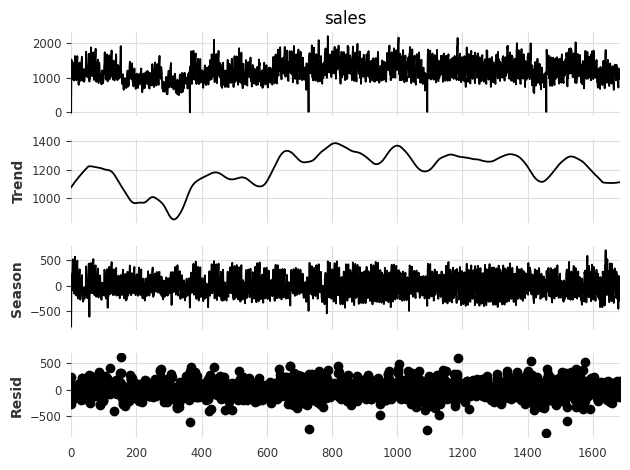

In [332]:
ts_data = df[df['family'] == 'SEAFOOD'].reset_index(drop=True)
ts_data = ts_data.groupby('date')[['sales','onpromotion']].sum().reset_index()

results = STL(ts_data['sales'],period=56).fit()
results.plot()
plt.show()

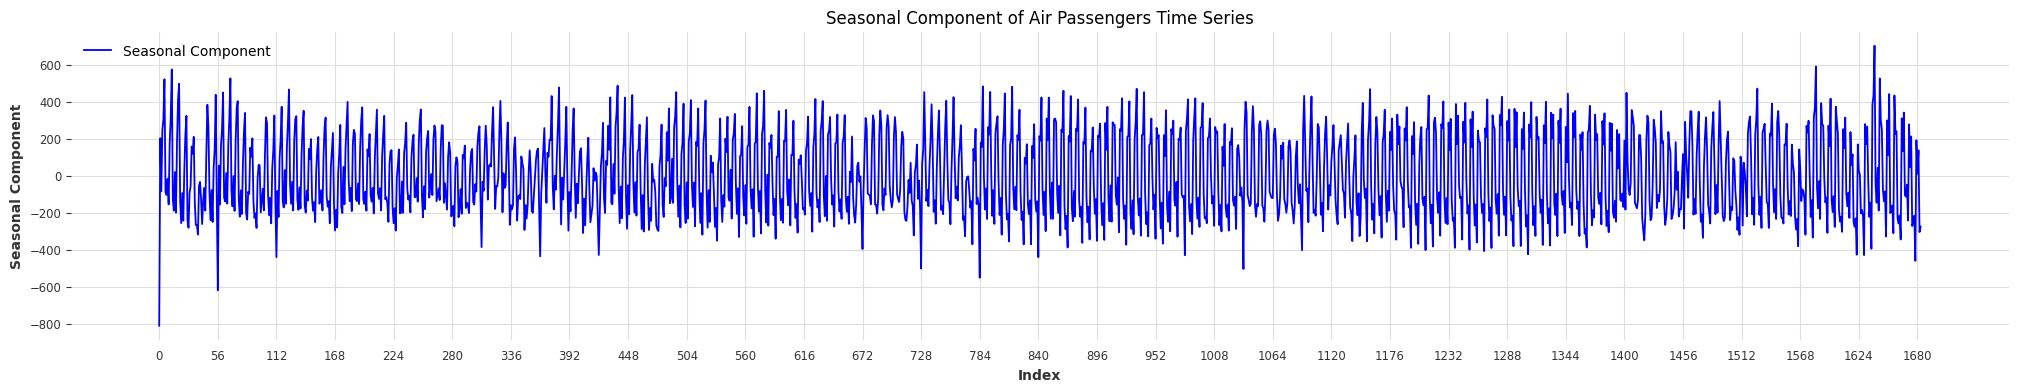

In [333]:
plt.figure(figsize=(25, 4))
plt.plot(results.seasonal, label='Seasonal Component',color='blue')
plt.title('Seasonal Component of Air Passengers Time Series')
plt.xlabel('Index')
plt.ylabel('Seasonal Component')
plt.xticks([i for i in range(0,1700,56)])
plt.legend()
plt.show()

# ARIMA using Box-Jenkins

In [ ]:
res_df = pd.DataFrame()
for i,data in cat_df.iterrows():
    results = train_forecasting_model(df, model_name=i,test_time=dt(2016,8,1), tgt_category=data['category'], p=data['pacf__ord'], d=data['adf_ord'], q=data['acf_ord'])
    res_df = pd.concat([res_df,results]).reset_index(drop=True)

category     AUTOMOTIVE
cv2            0.108706
adi            1.000594
class            Smooth
adf_ord               0
acf_ord              90
pacf__ord            89
period                7
Name: 0, dtype: object
category     BABY CARE
cv2           1.772913
adi           1.890011
class            Lumpy
adf_ord              4
acf_ord             90
pacf__ord           82
period               7
Name: 1, dtype: object
category       BEAUTY
cv2          0.250428
adi               1.0
class          Smooth
adf_ord             4
acf_ord            90
pacf__ord          67
period              7
Name: 2, dtype: object
category     BEVERAGES
cv2           0.240051
adi                1.0
class           Smooth
adf_ord              4
acf_ord             90
pacf__ord           69
period               7
Name: 3, dtype: object
category         BOOKS
cv2          11.507761
adi           5.867596
class            Lumpy
adf_ord              0
acf_ord             90
pacf__ord           84
period     